# In Part 3 of this project, we build a hybrid movie recommender. For each movie, input its overview (a short description of the movie) to distilled BERT for document embedding (a 768 dimensional vector). Connect a dense layer to shrink its dimension and take the dot product of this shrunk overview embedding with a vector of user embedding to get the prediction from the content-based recommender system. Meanwhile we get a second prediction from the familiar collaborative-filtering based method. We combine these two predictions using dense layers. Eventually we evaluate the model using metrics like RMSE, MAE and MAP@K. 

### import dependencies

In [1]:
%%capture
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install transformers
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [2]:
import random
import time
import sys
import gc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import pickle
from tqdm import tqdm
import transformers

**remove useless warnings**

In [3]:
import warnings
warnings.filterwarnings('ignore')

## import data

In [4]:
df_movie_title_filtered=pd.read_pickle('df_movie_titles_filtered.pkl')
df_train_filtered=pd.read_pickle('df_train_filtered.pkl')
df_val_filtered=pd.read_pickle('df_val_filtered.pkl')
df_test_filtered=pd.read_pickle('df_test_filtered.pkl')

In [5]:
df_train_filtered.shape, df_val_filtered.shape, df_test_filtered.shape

((58526535, 3), (79336, 3), (79463, 3))

### select a subset of data

In [6]:
# sub_users=list(df_test_filtered['User'].unique())
# random.Random(7).shuffle(sub_users)
# sub_users=sub_users[:1000]

# df_train_filtered=df_train_filtered[df_train_filtered['User'].isin(sub_users)]
# df_val_filtered=df_val_filtered[df_val_filtered['User'].isin(sub_users)]
# df_test_filtered=df_test_filtered[df_test_filtered['User'].isin(sub_users)]
# df_train_filtered.shape, df_val_filtered.shape, df_test_filtered.shape

## prepare tokens and masks BERT model

**create a function that makes BERT input features from overview text** <br>
**the function is copied from: https://github.com/dipanjanS/deep_transfer_learning_nlp_dhs2019/blob/master/notebooks/6%20-%20Transformers%20-%20DistilBERT.ipynb**

In [7]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in docs:
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = [all_ids, all_masks]
    
    return encoded

In [8]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [9]:
df_movie_title_filtered['Movie']=df_movie_title_filtered.index

In [10]:
MAX_SEQ_LENGTH = 300 # slightly larger than 274

feature_id_dic={}
feature_mask_dic={}

for i in tqdm(range(df_movie_title_filtered.shape[0])):
    movie=df_movie_title_filtered.iloc[i, 3]
    overview=df_movie_title_filtered.iloc[i, 2]
    temp=create_bert_input_features(tokenizer, [overview], max_seq_length=MAX_SEQ_LENGTH)
    feature_id_dic[movie] = temp[0][0]
    feature_mask_dic[movie] = temp[1][0]

100%|██████████| 6551/6551 [00:05<00:00, 1127.70it/s]


## use a BERT model to do paragraph embedding. We won't train this model

In [11]:
inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

layer=transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
layer.trainable=False
hidden_state = layer(inputs)[0]
print(hidden_state.shape)
output = hidden_state[:, 0]

model = Model(inputs=[inp_id, inp_mask], outputs=output)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5))

2022-01-12 17:22:07.201009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 17:22:07.209783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 17:22:07.210391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 17:22:07.212098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 17:22:07.212684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

(None, 300, 768)


### bert_dic is the actual dictionary that maps movie ids to movie overview embeddings

In [12]:
bert_dic={}

for movie in feature_id_dic:
    inp_id=np.array([feature_id_dic[movie]])
    inp_mask=np.array([feature_mask_dic[movie]])
    bert_dic[movie]=list(model.predict([inp_id, inp_mask])[0])

2022-01-12 17:22:11.124830: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### save bert_dic

In [13]:
bert_dic_list=[]
for key in list(bert_dic.keys()):
    bert_dic_list.append([key, bert_dic[key]])
    
with open('bert_dic_list.txt', 'wb') as fp:
    pickle.dump(bert_dic_list, fp)

### load bert_dic

In [14]:
# with open('bert_dic_list.txt', 'rb') as fp:
#     bert_dic_list=pickle.load(fp)

# bert_dic={}
    
# for ele in bert_dic_list:
#     bert_dic[ele[0]]=ele[1]

# del bert_dic_list

### take a look at a vector in bert_dic

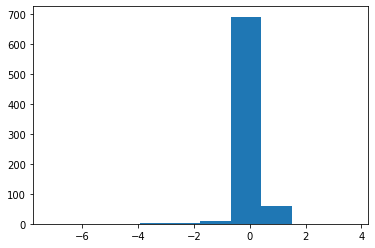

In [15]:
fig, ax = plt.subplots()
ax.hist(bert_dic[list(bert_dic.keys())[7]]);

## make sure all users in val and test sets are included in train set

In [16]:
l1=list(df_train_filtered['User'].unique())
l2=list(df_val_filtered['User'].unique())
l3=list(df_test_filtered['User'].unique())
len(l1), len(l2), len(l3)

(150245, 57042, 57069)

In [17]:
check=True
l1_dic={}

for ele in l1:
    l1_dic[ele]=True
    
for ele in l2:
    if ele not in l1_dic:
        check=False
        break

if check:
    print('val no problem')
else:
    print('val error')
    
check=True
for ele in l3:
    if ele not in l1_dic:
        check=False
        break

if check:
    print('test no problem')
else:
    print('test error')

del l1, l2, l3, l1_dic

val no problem
test no problem


## make sure all movies in val and test sets are included in train set

In [18]:
l1=list(df_train_filtered['Movie'].unique())
l2=list(df_val_filtered['Movie'].unique())
l3=list(df_test_filtered['Movie'].unique())
len(l1), len(l2), len(l3)

(4239, 4037, 4046)

In [19]:
check=True
l1_dic={}

for ele in l1:
    l1_dic[ele]=True
    
for ele in l2:
    if ele not in l1_dic:
        check=False
        break

if check:
    print('val no problem')
else:
    print('val error')
    
check=True
for ele in l3:
    if ele not in l1_dic:
        check=False
        break

if check:
    print('test no problem')
else:
    print('test error')

del l1, l2, l3, l1_dic

val no problem
test no problem


## prepare features

### user embeddings

**user_id_mapping**

In [20]:
user_id_mapping = {id:i for i, id in enumerate(df_train_filtered['User'].unique())}

In [21]:
user_id_mapping_list=[]
for key in list(user_id_mapping.keys()):
    user_id_mapping_list.append([key, user_id_mapping[key]])
    
with open('filtered_user_id_mapping_list.txt', 'wb') as fp:
    pickle.dump(user_id_mapping_list, fp)

**convert user_id using user_id_mapping**

In [22]:
train_user=df_train_filtered['User'].map(user_id_mapping).values
val_user=df_val_filtered['User'].map(user_id_mapping).values
test_user=df_test_filtered['User'].map(user_id_mapping).values

### movie embeddings

**movie_id_mapping**

In [23]:
movie_id_mapping = {id:i for i, id in enumerate(df_train_filtered['Movie'].unique())}

In [24]:
movie_id_mapping_list=[]
for key in list(movie_id_mapping.keys()):
    movie_id_mapping_list.append([key, movie_id_mapping[key]])
    
with open('filtered_movie_id_mapping_list.txt', 'wb') as fp:
    pickle.dump(movie_id_mapping_list, fp)

**create movie id feature for movie embeddings**

In [25]:
train_movie=df_train_filtered['Movie'].map(movie_id_mapping).values
val_movie=df_val_filtered['Movie'].map(movie_id_mapping).values
test_movie=df_test_filtered['Movie'].map(movie_id_mapping).values

### movie ids will later be mapped to bert [CLS] token 

In [26]:
train_bert=df_train_filtered['Movie'].values
val_bert=df_val_filtered['Movie'].values
test_bert=df_test_filtered['Movie'].values

### again we need rank_dic which stores the average movie ratings sorted from high to low

In [27]:
# Mean rating for all movies
C = df_train_filtered['Rating'].mean()

# Mean rating for all movies separately
R = df_train_filtered.groupby(['Movie']).mean()['Rating'].values

# Rating freqency for all movies separately
v = df_train_filtered.groupby(['Movie']).count()['Rating'].values

# Number of minimum votes to be considered
m = v.min()

# Weighted formula to compute the weighted rating
weighted_score = pd.DataFrame(v/(v+m)*R+m/(v+m)*C, columns=['weighted_score'])
weighted_score.set_index(np.sort(df_train_filtered['Movie'].unique()), inplace=True)
weighted_score.sort_values(by='weighted_score', ascending=False, inplace=True)

In [50]:
print('number of minimum votes: {}'.format(m))

number of minimum votes: 566


In [28]:
from collections import OrderedDict

rank_dic=OrderedDict()

for i in range(weighted_score.shape[0]):
    rank_dic[weighted_score.index[i]]=weighted_score.iloc[i,0]

### create labels

In [29]:
train_Y=df_train_filtered['Rating'].values.copy()-df_train_filtered['Movie'].map(rank_dic).values.copy()
val_Y=df_val_filtered['Rating'].values.copy()-df_val_filtered['Movie'].map(rank_dic).values.copy()

## model building

### our dataset will be too large in the original form of shape=(None, 768), so we need to define a batch_generator

In [30]:
def batch_generator(X0, X1, X2, Y, batch_size): 
    number_of_batches = X0.shape[0]//batch_size
    counter=0
    shuffle_index = np.arange(Y.shape[0])
    np.random.shuffle(shuffle_index)
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X0_batch = X0[index_batch]
        X1_batch = X1[index_batch]
        X2_batch = X2[index_batch].copy() # use .copy() to prevent modifying the original data X2
        X2_batch = np.array(pd.Series(X2_batch).map(bert_dic).tolist())
        Y_batch = Y[index_batch]
        counter += 1
        yield [X0_batch, X1_batch, X2_batch], Y_batch
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

## define the model

In [31]:
# reserve some spaces for new users, for users who haven't rated any movies, recommend weighted average
users=len(user_id_mapping)+100
# users=len(user_id_mapping)
movies=len(movie_id_mapping)
embedding_size = 128
# regularization term for user embedding
regu=1e-7
# 3e-6 works well for hybrid method
learning_rate=1e-4

#################################################################################################

# use Input() to create tensors for - 'user' 
user_id_input = Input(shape=(1,), name='user')

# Create embedding layer for users 
user_embedding_collaborative = Embedding(output_dim=embedding_size, 
                               input_dim=users,
                               input_length=1, 
                               embeddings_regularizer=tf.keras.regularizers.l2(regu))(user_id_input)

user_vector_collaborative = Reshape([embedding_size])(user_embedding_collaborative)

user_embedding_bert = Embedding(output_dim=embedding_size, 
                               input_dim=users,
                               input_length=1, 
                               embeddings_regularizer=tf.keras.regularizers.l2(regu))(user_id_input)

user_vector_bert = Reshape([embedding_size])(user_embedding_bert)

#################################################################################################

# use Input() to create tensors for - 'movie'
movie_id_input = Input(shape=(1,), name='movie')

# Create embedding layer for users 
movie_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=movies,
                           input_length=1, 
                           embeddings_regularizer=tf.keras.regularizers.l2(regu))(movie_id_input)

movie_vector = Reshape([embedding_size])(movie_embedding)

#################################################################################################

inp_bert = Input(shape=(768,), name='bert')
bert_vector = Dense(embedding_size)(inp_bert)
# bert_vector = inp_bert

#################################################################################################

output1 = Dot(1, normalize=False)([user_vector_collaborative, movie_vector])
output2 = Dot(1, normalize=False)([user_vector_bert, bert_vector])
temp = Concatenate()([output1, output2])
temp = Dense(10)(temp)
temp = Dense(10)(temp)
output = Dense(1)(temp)

# output = Dot(1, normalize=False)([user_vector, movie_vector])
# temp = Concatenate()([user_vector, movie_vector, bert_vector])
# temp = Dense(64)(temp)
# temp = BatchNormalization()(temp)
# output = Dense(1)(temp)

model = Model(inputs=[user_id_input, movie_id_input, inp_bert], outputs=output)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [32]:
# model = keras.models.load_model('./hybrid.h5')

## train the model

In [33]:
batch_size=4096
nb_epoch=100
steps_per_epoch=train_user.shape[0]//batch_size
# steps_per_epoch=100


es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit_generator(generator=batch_generator(train_user, train_movie, train_bert, train_Y, batch_size),
                    epochs=nb_epoch,
                    callbacks=[es],
                    validation_data=([val_user, val_movie,\
                                      np.array(pd.Series(val_bert).map(bert_dic).tolist())], val_Y),
                    steps_per_epoch=steps_per_epoch)

Epoch 1/100
14288/14288 [==============================] - 3541s 248ms/step - loss: 0.7951 - val_loss: 0.7259
Epoch 2/100
14288/14288 [==============================] - 3517s 246ms/step - loss: 0.6471 - val_loss: 0.6748
Epoch 3/100
14288/14288 [==============================] - 3511s 246ms/step - loss: 0.5655 - val_loss: 0.6713
Epoch 4/100
14288/14288 [==============================] - 3525s 247ms/step - loss: 0.5076 - val_loss: 0.6821
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


## save the hybrid model

In [34]:
model.save('hybrid.h5')

## compare with the collaborative-filtering based model

In [35]:
# def batch_generator(X0, X1, Y, batch_size): 
#     number_of_batches = X0.shape[0]//batch_size
#     counter=0
#     shuffle_index = np.arange(Y.shape[0])
#     np.random.shuffle(shuffle_index)
#     while 1:
#         index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
#         X0_batch = X0[index_batch]
#         X1_batch = X1[index_batch]
#         Y_batch = Y[index_batch]
#         counter += 1
#         yield [X0_batch, X1_batch], Y_batch
#         if (counter >= number_of_batches):
#             np.random.shuffle(shuffle_index)
#             counter=0

# ############################################################################################       
            
# users=len(user_id_mapping)
# movies=len(movie_id_mapping)
# embedding_size = 128

# # use Input() to create tensors for - 'user' and 'movie'
# user_id_input = Input(shape=(1,), name='user')
# movie_id_input =  Input(shape=(1,), name='movie')

# # Create embedding layer for users 
# user_embedding = Embedding(output_dim=embedding_size, 
#                            input_dim=users,
#                            input_length=1, 
#                            embeddings_regularizer=tf.keras.regularizers.l2(0.0000001),
#                            name='user_embedding')(user_id_input)

# # create embedding layer for movies 
# movie_embedding = Embedding(output_dim=embedding_size, 
#                            input_dim=movies,
#                            input_length=1, 
#                            embeddings_regularizer=tf.keras.regularizers.l2(0.0000001),
#                            name='movie_embedding')(movie_id_input)

# user_vector = Reshape([embedding_size])(user_embedding)
# movie_vector = Reshape([embedding_size])(movie_embedding)

# output = Dot(1, normalize=False)([user_vector, movie_vector])

# model = Model(inputs=[user_id_input, movie_id_input], outputs=output)
# model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# ############################################################################################

# batch_size = 1024
# nb_epoch = 200
# steps_per_epoch=train_user.shape[0]//batch_size

# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                       patience=2,
#                                       restore_best_weights=True,
#                                       verbose=1)

# model.fit_generator(generator=batch_generator(train_user, train_movie, train_Y, batch_size),
#                     epochs=nb_epoch,
#                     callbacks=[es],
#                     validation_data=([val_user, val_movie], val_Y),
#                     steps_per_epoch=steps_per_epoch)

## model evaluation

### define a function that makes prediction

In [38]:
def make_pred(user_id, movie_id, model, rank_dic):
#     if type(user_id)!=type('asdf'):
#         print('please enter a string for user id')
#         return None
#     if movie_id not in rank_dic:
#         print('movie id non-existent')
        
#     if user_id not in user_id_mapping:
#         user=users-1
#     else:
#         user=user_id_mapping[user_id]
    user=user_id_mapping[user_id]  
    movie=movie_id_mapping[movie_id]
    overview=bert_dic[movie_id]
    pred=model.predict([np.array([user]), np.array([movie])\
                       ,np.array([overview])\
                       ])[0,0]+rank_dic[movie_id]
    
    if pred<1: pred=1
    elif pred>5: pred=5
    return pred

### compare predictions of the content based model and the global model

In [39]:
movie_id=list(rank_dic.keys())[38]
user_id=list(df_test_filtered['User'].unique())[107]
make_pred(user_id, movie_id, model, rank_dic), rank_dic[movie_id]

(4.352449652380517, 4.131101053781083)

### MAE and RMSE evaluation

In [40]:
y_pred=model.predict([test_user, test_movie\
                      ,np.array(pd.Series(test_bert).map(bert_dic).tolist())\
                     ]).flatten()
y_pred+=df_test_filtered['Movie'].map(rank_dic).values

# clip the predicted score that's lower than 1 or larger than 5
y_pred = np.array(list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred)))

y_true = df_test_filtered['Rating']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
print("The RMSE Value for the content-based recommender:", rmse)
print("The MAE Value for the content-based recommender:", mae)

The RMSE Value for the content-based recommender: 0.8148861753668504
The MAE Value for the content-based recommender: 0.6305443603140987


### compare that with global recommender, we can see that content-based method is better

In [41]:
y_pred = df_test_filtered['Movie'].map(rank_dic).values
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
print("The RMSE Value for the global rated average recommender:", rmse)
print("The MAE Value for the global rated average recommender:", mae)

The RMSE Value for the global rated average recommender: 0.9843372810325114
The MAE Value for the global rated average recommender: 0.7928546636984719


### MAP@K Evaluation

### dictionary of unique users in the test set

In [42]:
test_user_ids={}

for ele in list(df_test_filtered['User'].unique()):
    test_user_ids[ele]=True

### create dictionaries that store movie id's and the average ratings of users in the train set

In [43]:
# {user_id: [movie_id_1, movie_id_2, ...], ...}
train_movie_ids={}
# {user_id: average_rating, ...}
train_movie_average_ratings={}
ct=0

for i in range(df_train_filtered.shape[0]):
    if i % (df_train_filtered.shape[0]//100)==0: 
        # print(str(ct)+' percent of job done')
        ct+=1
        
    user = df_train_filtered.iloc[i, 0]
    if user in test_user_ids:
        try:
            train_movie_ids[user].append(df_train_filtered.iloc[i,2])
            train_movie_average_ratings[user]+=df_train_filtered.iloc[i,1]
        except:
            train_movie_ids[user]=[df_train_filtered.iloc[i,2]]
            train_movie_average_ratings[user]=df_train_filtered.iloc[i,1]

for key in test_user_ids:
    train_movie_average_ratings[key]/=len(train_movie_ids[key])

### test_movie_ids is a dicitionary that stores positively rated movies in the test sets for each user in the test sets

In [44]:
# {user_id: [movie_id_1, movie_id_2, ...], ...}
test_movie_ids={}

for i in range(df_test_filtered.shape[0]):
    user=df_test_filtered.iloc[i,0]
    if df_test_filtered.iloc[i,1]>train_movie_average_ratings[user]:
        try:
            test_movie_ids[user].append(df_test_filtered.iloc[i,2])
        except:
            test_movie_ids[user]=[df_test_filtered.iloc[i,2]]

### save dictionaries above

In [45]:
filtered_test_movie_ids_list=[]
for key in test_movie_ids:
    filtered_test_movie_ids_list.append([key, test_movie_ids[key]])
    
with open('filtered_test_movie_ids_list.txt', 'wb') as fp:
    pickle.dump(filtered_test_movie_ids_list, fp)
    
############################################################

filtered_train_movie_ids_list=[]
for key in train_movie_ids:
    filtered_train_movie_ids_list.append([key, train_movie_ids[key]])
    
with open('filtered_train_movie_ids_list.txt', 'wb') as fp:
    pickle.dump(filtered_train_movie_ids_list, fp)
    
############################################################

filtered_train_movie_average_ratings_list=[]
for key in train_movie_average_ratings:
    filtered_train_movie_average_ratings_list.append([key, train_movie_average_ratings[key]])
    
with open('filtered_train_movie_average_ratings_list.txt', 'wb') as fp:
    pickle.dump(filtered_train_movie_average_ratings_list, fp)

### load the dictionaries

In [46]:
# with open('filtered_train_movie_ids_list.txt', 'rb') as fp:
#     train_movie_ids_list=pickle.load(fp)
    
# with open('filtered_train_movie_average_ratings_list.txt', 'rb') as fp:
#     train_movie_average_ratings_list=pickle.load(fp)
    
# with open('filtered_test_movie_ids_list.txt', 'rb') as fp:
#     test_movie_ids_list=pickle.load(fp)

# #####################################################################    

# # {user_id_1: [movie_id_1, movie_id_2, ...], ...}
# train_movie_ids={}
    
# for ele in train_movie_ids_list:
#     train_movie_ids[ele[0]]=ele[1]
    
# #####################################################################

# train_movie_average_ratings={}

# for ele in train_movie_average_ratings_list:
#     train_movie_average_ratings[ele[0]]=ele[1]
    
# #####################################################################

# # {user_id_1: [movie_id_3, ...], ...} 
# # the number of users in test_movie_ids is smaller than total number of users in the test set
# # because some users in the test set give all ratings as negative (lower than average in train set)
# test_movie_ids={}

# for ele in test_movie_ids_list:
#     test_movie_ids[ele[0]]=ele[1]

# del train_movie_ids_list, train_movie_average_ratings_list, test_movie_ids_list

**check the dimensions**

In [47]:
len(list(train_movie_ids.keys())), len(list(df_test_filtered['User'].unique()))

(57069, 57069)

### define a function that calculates map@k

In [48]:
def average_precision_at_k(rel: [int], pred: [int], k: int) -> float:
    # this function works only for a single user
    # rel is an list of movie id's for all relevant movies in the test set 
    # pred is the prediction of the model excluding those ratings already in the training set
    # pred is a list of movie id's whose scores are ranked from high to low
    # len(pred) should be large enough for k
    # k is the cutoff
    temp=0
    true_positive=0
    for i in range(min(k,len(pred))):
        if pred[i] in rel:
            true_positive+=1
            temp+=true_positive/(i+1)
    return temp/len(rel)

### loop through users in test set and apply the function we defined

In [61]:
result1=[]
result2=[]
user_list=list(test_movie_ids.keys())

mile=len(user_list)//100
ct=0

for i in range(len(user_list)):
    
    if ct%mile==1: 
        print(ct//mile)
        print('hybrid method', sum(result1)/len(result1))
        print('global method ', sum(result2)/len(result2))
    ct+=1

    user=user_list[i]

    rank_dic_copy=rank_dic.copy()

    rel=test_movie_ids[user]

    pred=[]
    # list of movies already rated in train set
    already=train_movie_ids[user]

    # remove movies that are already in the train set
    for ele in already:
        rank_dic_copy.pop(ele)

    # save a copy of movie ids
    aaa=list(rank_dic_copy.keys())
    
    # map movie ids to movie vocabulary number
    X_bert=np.array(pd.Series(np.array(aaa)).map(bert_dic).tolist())
    # map user ids to user vocabulary number
    X_user=pd.Series(np.array([user for i in range(X_bert.shape[0])])).map(user_id_mapping).values

    Y=model.predict([X_user, pd.Series(aaa).map(movie_id_mapping).values\
                     ,X_bert\
                    ])
    Y=Y[:,0]
    Y=list(Y)

    pred=[]
    for iii, y in enumerate(Y):
        pred.append([aaa[iii], y+rank_dic[aaa[iii]]])

    # sort by score from high to low
    pred.sort(key=lambda x : x[1], reverse=True)
    pred=np.array(pred)
    pred=pred[:,0]
    pred=list(pred)
    result1.append(average_precision_at_k(rel, pred, 100000))

    result2.append(average_precision_at_k(rel, aaa, 100000))

0
hybrid method 0.002702702702702703
global method  0.0008665511265164644
1
hybrid method 0.024630549410313972
global method  0.015583704186061384
2
hybrid method 0.03051648679072313
global method  0.016838426262910218
3
hybrid method 0.027662741422671566
global method  0.016216221735840558
4
hybrid method 0.027515815421612987
global method  0.019360936150991565
5
hybrid method 0.02844518547683355
global method  0.018375978017756988
6
hybrid method 0.029639613259585022
global method  0.017702749237732594
7
hybrid method 0.030935490988038834
global method  0.0183656036718676
8
hybrid method 0.030954449446325482
global method  0.0188914649345625
9
hybrid method 0.031645662713360556
global method  0.01890799591212673
10
hybrid method 0.03133774279609866
global method  0.018675183903417512
11
hybrid method 0.031589727506169965
global method  0.018086998282742326
12
hybrid method 0.030785269800432502
global method  0.018535452730713855
13
hybrid method 0.030901429937181413
global method  0.

In [ ]:
# hybrid
# 3000, 0.013, 0.016, learning rate=3e-4
# 1000, 0.0066, 0.0075, learning rate=3e-4
# 1000, 0.009X, 0.0075, learning rate=3e-6
# 3000, 0.012, 0.015, learning rate=3e-6
# collaborative
# 1000, 0.0079, 0.0075

In [62]:
print('mean average precision for hybrid method is {}'.format(sum(result1)/len(result1)))
print('mean average precision for global method is {}'.format(sum(result2)/len(result2)))

mean average precision for hybrid method is 0.03176126849116085
mean average precision for global method is 0.018598455323007967


**Since we set the k->infinity in map@k, the list of average precisions should not contain zeros.** 

In [63]:
for ele in result1:
    if ele==0: print('something is wrong')
        
for ele in result2:
    if ele==0: print('something is wrong')